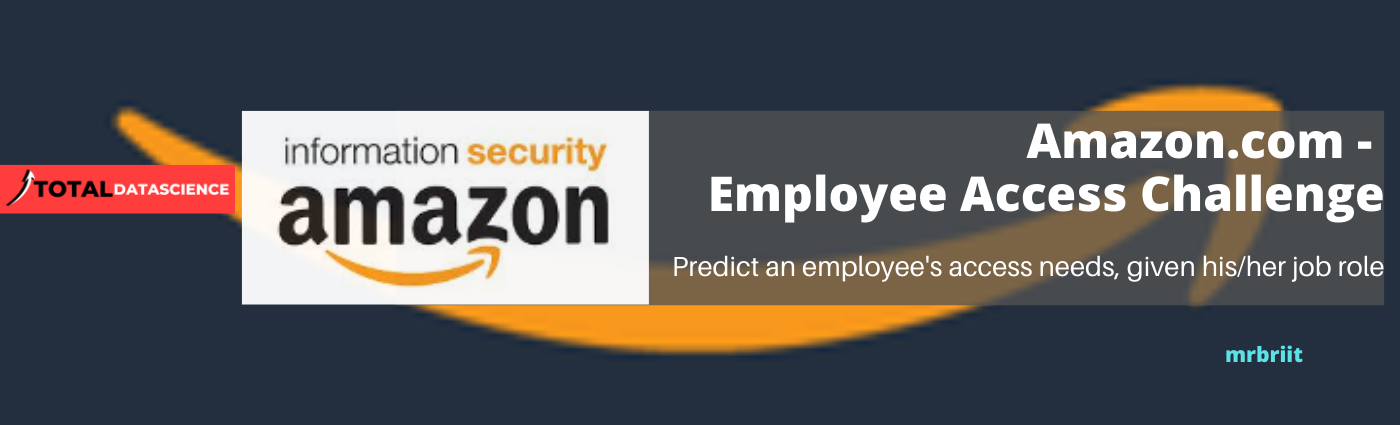

# Amazon.com - Employee Access Challenge

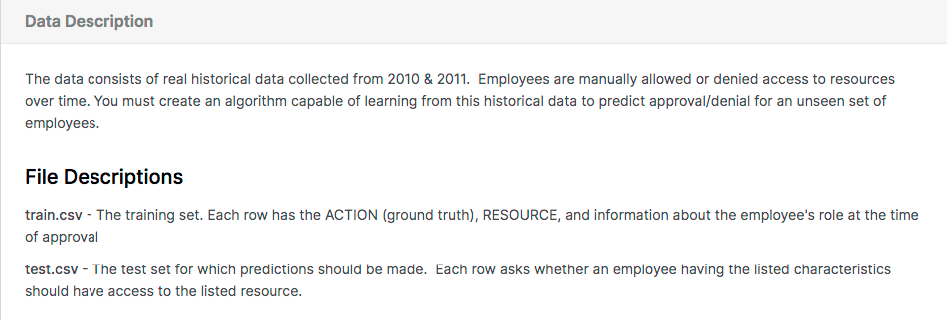

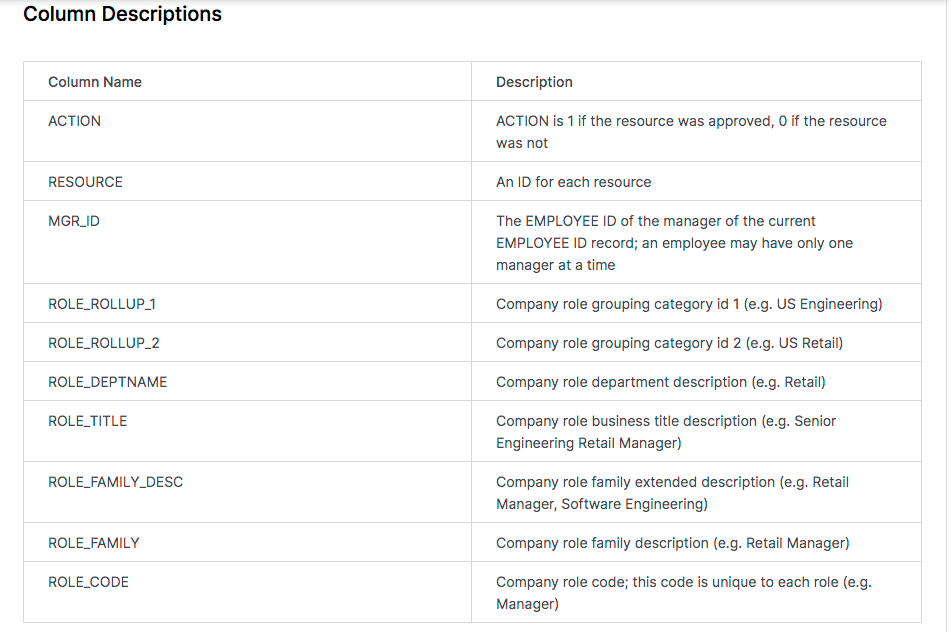

In [ ]:
from pyforest import*
lazy_imports()

ModuleNotFoundError: ignored

In [ ]:
train=pd.read_csv("amazontrain.csv")

In [ ]:
test=pd.read_csv("amazontest.csv")

In [ ]:
train.head()

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
test.head()

<br>
<br>

# **CatBoost**



CatBoost is an algorithm for gradient boosting on decision trees. It is developed by Yandex researchers and engineers, and is used for search, recommendation systems, personal assistant, self-driving cars, weather prediction and many other tasks at Yandex and in other companies, including CERN, Cloudflare, Careem taxi. It is in open-source and can be used by anyone.


Procedure for other gradient boosting algorithms (XG boost, Light GBM)
Step 1: Consider all (or a sample ) the data points to train a highly biased model.

Step 2: Calculate residuals (errors) for each data point.

Step 3: Train another model with the same data points and corresponding residuals (errors) as class labels.

Step 4: Repeat Step 2 & Step 3 ( for n iterations).

This procedure is prone to overfitting, because we are calculating residuals of each data point by using the model that has already been trained on same set of data points.

<br>

**Advantages of CatBoost Library**

**Performance:** 

CatBoost provides state of the art results and it is competitive with any leading machine learning algorithm on the performance front.

**Handling Categorical features automatically:**

We can use CatBoost without any explicit pre-processing to convert categories into numbers. CatBoost converts categorical values into numbers using various statistics on combinations of categorical features and combinations of categorical and numerical features. You can read more about it here.

**Robust:**

It reduces the need for extensive hyper-parameter tuning and lower the chances of overfitting also which leads to more generalized models. Although, CatBoost has multiple parameters to tune and it contains parameters like the number of trees, learning rate, regularization, tree depth, fold size, bagging temperature and others. You can read about all these parameters here.

**Easy-to-use:** You can use CatBoost from the command line, using an user-friendly API for both Python and R.


*Reference for Gradient Boosting* : https://bit.ly/2LOJQYD

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
# Loading data directly from CatBoost
from catboost.datasets import amazon

traindf, testdf = amazon()

In [ ]:
traindf.shape

(32769, 10)

In [ ]:
testdf.shape

(58921, 10)

In [ ]:
traindf.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


<br>

**ACTION** is our target column

<br>

In [ ]:
testdf.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [ ]:
traindf.apply(lambda x: len(x.unique()))

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [ ]:
traindf['MGR_ID'].value_counts()

770      152
2270      99
2594      82
1350      71
2014      67
        ... 
97000      1
81506      1
12517      1
50296      1
22355      1
Name: MGR_ID, Length: 4243, dtype: int64

## Distribution of Features

**Distplot**

In [ ]:
for i in traindf.describe().columns:
    sns.distplot(traindf[i].dropna())
    plt.show()

NameError: ignored

<br>

**Boxplot**

In [ ]:
traindf['ACTION'].value_counts()

In [ ]:
for i in traindf.describe().columns:
    sns.boxplot(traindf[i].dropna())
    plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(traindf.corr(),annot=True,cmap='viridis',linewidth=1)

In [ ]:
traindf.head()

In [ ]:
testdf.head()

# Model Building

In [ ]:
y = traindf['ACTION']

X = traindf.drop('ACTION',axis=1) 

X_test = testdf.drop('id',axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
%%time

params = {'loss_function':'Logloss', # objective function
          'eval_metric':'AUC', # metric
          'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': 1
         }
catmodel_1 = CatBoostClassifier(**params)
catmodel_1.fit(X_train, y_train, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_valid, y_valid), # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
         );

In [ ]:
#catmodel_1.plot_tree(tree_idx=0)

# https://catboost.ai/docs/concepts/python-reference_catboostclassifier_plot_tree.html

In [ ]:
X.head()

In [ ]:
#In the above model CatBoost treated categorical features as numerical ones. Thus, the categories were ranked. We need to specify which features are categorical

categorical_features= list(range(X.shape[1]))
print(categorical_features)

In [ ]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': categorical_features,
          'verbose': 200,
          'random_seed': 1
         }
catmodel = CatBoostClassifier(**params)
catmodel.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
          use_best_model=True);
        

<br>

### Cross Validation

In [ ]:
from catboost import cv




params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed':1
         }

# pool for Dataset processing.

total_train_data = Pool(data=X,
                      label=y,
                      cat_features= categorical_features
                     )

scores = cv(pool=total_train_data,
            params=params, 
            fold_count=4,
            seed=1, 
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
           )


In [ ]:
feature_imp=catmodel.get_feature_importance(prettified=True)
feature_imp

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=feature_imp, orient='V');
plt.title('CatBoost features importance:');

In [ ]:
predictions=catmodel.predict_proba(X_test)

In [ ]:
predictions 

In [ ]:
predictions=catmodel.predict(X_test)
predictions

In [ ]:
catmodel.score(X_valid, y_valid)

In [ ]:
traindf['ACTION'].value_counts()

<br>

**IMPORTANT**

Note that our target column (**ACTION**) contains **30872** 1s and only **1897** 0s. This is an indication of data imbalance. You can deal with this and use the same steps above to build the algorithm.

If you are not familiar with how to deal with **data imbalance**, watch the **Credit Card Fraud Detection** project video to get to know how to solve this.

<br>
<br>

## Alternatively

Consider building a **Logistic Regression** on same dataset to compare the results

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
